<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/F%20CX_CB_Time_Series_V1_Expanded_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series V1 Expanded Models - Standardized Metrics Implementation

In [1]:
!nvidia-smi

Sat Sep 20 18:27:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

# Example: Move a tensor to the GPU
x = torch.randn(10, 10).to(device)

# Example: Move a model to the GPU
# model = YourModel().to(device)

Using GPU: Tesla T4


In [3]:
print("🖥️ COMPUTATIONAL ENVIRONMENT CHECK - V1 EXPANDED")
print("=" * 55)

# GPU Check
try:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('❌ Not connected to a GPU')
        print('💡 Neural models will run on CPU (slower)')
        GPU_AVAILABLE = False
    else:
        print('✅ GPU Available:')
        print(gpu_info)
        GPU_AVAILABLE = True
except:
    print('❌ GPU check failed - assuming no GPU')
    GPU_AVAILABLE = False

# RAM Check
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print(f'\n💾 RAM Status: {ram_gb:.1f} GB available')

if ram_gb < 20:
    print('⚠️ Standard RAM - may limit large ensemble grid searches')
    HIGH_RAM = False
else:
    print('✅ High-RAM runtime - can handle complex model combinations!')
    HIGH_RAM = True

# Set computational strategy based on resources
print(f"\n🎯 COMPUTATIONAL STRATEGY:")
if GPU_AVAILABLE and HIGH_RAM:
    print("   🚀 FULL POWER: GPU + High RAM - All models enabled")
    ENABLE_NEURAL = True
    ENABLE_LARGE_GRIDS = True
    ENABLE_COMPLEX_MODELS = True
elif GPU_AVAILABLE:
    print("   ⚡ GPU enabled, moderate RAM - Neural models OK")
    ENABLE_NEURAL = True
    ENABLE_LARGE_GRIDS = False
    ENABLE_COMPLEX_MODELS = True
elif HIGH_RAM:
    print("   🧠 High RAM, no GPU - Complex models OK, neural slower")
    ENABLE_NEURAL = True  # Still possible but slower
    ENABLE_LARGE_GRIDS = True
    ENABLE_COMPLEX_MODELS = True
else:
    print("   💡 Standard setup - All models enabled (may be slower)")
    ENABLE_NEURAL = True
    ENABLE_LARGE_GRIDS = False
    ENABLE_COMPLEX_MODELS = True

print("=" * 55)

🖥️ COMPUTATIONAL ENVIRONMENT CHECK - V1 EXPANDED
✅ GPU Available:
Sat Sep 20 18:27:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             27W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |      

In [4]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install tensorflow scikit-learn
!pip install tbats
!pip install keras
!pip install torch

!pip install pmdarima

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
print("\n📚 IMPORTING LIBRARIES - V1 EXPANDED")
print("=" * 40)

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical and time series
from scipy import stats
from scipy.stats import jarque_bera, shapiro, mode, trim_mean, gmean
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Advanced time series models
try:
    from statsmodels.tsa.statespace.tools import diff
    from statsmodels.tsa.seasonal import STL
    ADVANCED_TS_AVAILABLE = True
    print("✅ Advanced time series models available")
except ImportError:
    ADVANCED_TS_AVAILABLE = False
    print("⚠️ Some advanced TS models may not be available")

# TBATS (Multiple seasonality handling)
try:
    from tbats import TBATS
    TBATS_AVAILABLE = True
    print("✅ TBATS available")
except ImportError:
    TBATS_AVAILABLE = False
    print("⚠️ TBATS not available - install with: pip install tbats")

# Prophet
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
    print("✅ Prophet available")
except ImportError:
    PROPHET_AVAILABLE = False
    print("⚠️ Prophet not available")

# Machine Learning models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Neural networks (expanded implementation)
if 'ENABLE_NEURAL' in globals() and ENABLE_NEURAL:
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Sequential, Model
        from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, Input, SimpleRNN, GRU
        from tensorflow.keras.optimizers import Adam
        print("✅ TensorFlow/Keras available for neural models")
        KERAS_AVAILABLE = True
    except ImportError:
        print("⚠️ TensorFlow not available - skipping neural models")
        KERAS_AVAILABLE = False
        ENABLE_NEURAL = False
else:
    KERAS_AVAILABLE = False

# Visualization setup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Model versioning
MODEL_VERSION = "V1_EXPANDED"
print(f"\n🏷️ MODEL VERSION: {MODEL_VERSION}")
print("📊 Phase 1 Expanded: ALL Basic Statistical + Advanced Time Series + Hybrid Neural Models")

print("\n✅ Expanded Setup Complete - Ready for Full Model Suite!")


📚 IMPORTING LIBRARIES - V1 EXPANDED
✅ Advanced time series models available
✅ TBATS available
✅ Prophet available

🏷️ MODEL VERSION: V1_EXPANDED
📊 Phase 1 Expanded: ALL Basic Statistical + Advanced Time Series + Hybrid Neural Models

✅ Expanded Setup Complete - Ready for Full Model Suite!


In [2]:
try:
    # Neural model initialization
    from tensorflow import keras
except ImportError:
    print("Neural models disabled - missing dependencies")
    enable_neural = False

In [3]:
def load_call_center_data_v1_expanded(file_path='enhanced_eda_data.csv'):
    """
    Load call center data with market integration for V1 Expanded models
    """

    print("📂 LOADING CALL CENTER DATA (V1 EXPANDED)")
    print("=" * 45)

    try:
        # Load main data file
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        print(f"✅ Loaded {len(df)} records from {file_path}")

        # Auto-detect call volume column
        volume_cols = ['calls', 'Calls', 'call_volume', 'Call_Volume', 'volume', 'Volume']
        volume_col = None

        for col in volume_cols:
            if col in df.columns:
                volume_col = col
                break

        if volume_col is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            volume_col = numeric_cols[0] if len(numeric_cols) > 0 else df.columns[0]

        print(f"🎯 Call volume column: {volume_col}")

        # Standardize column name
        if volume_col != 'calls':
            df = df.rename(columns={volume_col: 'calls'})

        # DATA CLEANING: Remove first and last rows
        print("🧹 DATA CLEANING: Removing first and last rows")
        original_len = len(df)
        if len(df) > 2:
            df = df.iloc[1:-1]
            print(f"   ✅ Cleaned: {original_len} → {len(df)} rows")

        # Market data integration (enhanced)
        expected_market_cols = [
            '^VIX_close', 'SPY_close', 'SPY_volume', 'QQQ_close', 'QQQ_volume',
            'DX-Y.NYB_close', 'GC=F_close', 'GC=F_volume', 'BTC-USD_close',
            'BTC-USD_volume', 'ETH-USD_close', 'ETH-USD_volume'
        ]

        existing_market_cols = [col for col in expected_market_cols if col in df.columns]

        if existing_market_cols:
            print(f"✅ Market data found: {len(existing_market_cols)} columns")

            # Enhanced market features for hybrid models
            if '^VIX_close' in df.columns:
                df['vix_high'] = (df['^VIX_close'] > df['^VIX_close'].quantile(0.8)).astype(int)
                df['vix_spike'] = (df['^VIX_close'].pct_change() > 0.2).astype(int)
                df['vix_returns'] = df['^VIX_close'].pct_change()
                df['vix_volatility'] = df['vix_returns'].rolling(7).std()

            if 'SPY_close' in df.columns:
                df['spy_returns'] = df['SPY_close'].pct_change()
                df['market_stress'] = (df['spy_returns'] < -0.02).astype(int)
                df['spy_volatility'] = df['spy_returns'].rolling(7).std()
                df['spy_momentum'] = df['SPY_close'].rolling(5).mean() / df['SPY_close'].rolling(20).mean()

            if 'BTC-USD_close' in df.columns:
                df['btc_returns'] = df['BTC-USD_close'].pct_change()
                df['crypto_volatility'] = df['btc_returns'].rolling(7).std()
                df['btc_extreme_move'] = (abs(df['btc_returns']) > 0.1).astype(int)

            # Advanced market uncertainty composite
            uncertainty_features = []
            if '^VIX_close' in df.columns:
                uncertainty_features.append(df['^VIX_close'])
            if 'spy_volatility' in df.columns:
                uncertainty_features.append(df['spy_volatility'] * 100)
            if 'crypto_volatility' in df.columns:
                uncertainty_features.append(df['crypto_volatility'] * 100)

            if uncertainty_features:
                uncertainty_matrix = pd.concat(uncertainty_features, axis=1)
                df['market_uncertainty_index'] = uncertainty_matrix.mean(axis=1)
                df['market_regime'] = (df['market_uncertainty_index'] > df['market_uncertainty_index'].quantile(0.7)).astype(int)

        print(f"\n📊 FINAL DATASET OVERVIEW")
        print("-" * 25)
        print(f"   Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
        print(f"   Total days: {len(df)}")
        print(f"   Total columns: {len(df.columns)}")
        print(f"   Call volume range: {df['calls'].min():.0f} to {df['calls'].max():.0f}")

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

In [4]:
df_raw = load_call_center_data_v1_expanded()

if df_raw is None:
    raise Exception("Data loading failed")

📂 LOADING CALL CENTER DATA (V1 EXPANDED)
✅ Loaded 978 records from enhanced_eda_data.csv
🎯 Call volume column: calls
🧹 DATA CLEANING: Removing first and last rows
   ✅ Cleaned: 978 → 976 rows
✅ Market data found: 12 columns

📊 FINAL DATASET OVERVIEW
-------------------------
   Date range: 2023-01-02 to 2025-09-03
   Total days: 976
   Total columns: 32
   Call volume range: 3462 to 24724


In [5]:
def create_time_series_splits_v1_expanded(df, n_splits=5, test_size=7, gap=0):
    """Create time series cross-validation splits for V1 Expanded models"""

    print("🔀 TIME SERIES CROSS-VALIDATION SETUP (V1 EXPANDED)")
    print("=" * 50)

    splits = []
    total_size = len(df)

    for i in range(n_splits):
        test_end = total_size - i * test_size
        test_start = test_end - test_size
        train_end = test_start - gap

        if train_end < 30:
            break

        train_idx = df.index[:train_end]
        test_idx = df.index[test_start:test_end]

        splits.append({
            'train_idx': train_idx,
            'test_idx': test_idx,
            'train_size': len(train_idx),
            'test_size': len(test_idx),
            'split_date': test_idx[0] if len(test_idx) > 0 else None
        })

    print(f"✅ Created {len(splits)} cross-validation splits")
    return splits

cv_splits = create_time_series_splits_v1_expanded(df_raw)

🔀 TIME SERIES CROSS-VALIDATION SETUP (V1 EXPANDED)
✅ Created 5 cross-validation splits


In [6]:
def create_features_v1_expanded(df_train, df_test=None):
    """
    Enhanced feature engineering for V1 Expanded models
    Includes all features for hybrid neural models
    """

    print("🛠️ ENHANCED FEATURE ENGINEERING V1 EXPANDED")
    print("=" * 45)

    df_features_train = df_train.copy()

    # TIME-BASED FEATURES (Enhanced)
    df_features_train['year'] = df_features_train.index.year
    df_features_train['month'] = df_features_train.index.month
    df_features_train['day'] = df_features_train.index.day
    df_features_train['dayofweek'] = df_features_train.index.dayofweek
    df_features_train['dayofyear'] = df_features_train.index.dayofyear
    df_features_train['quarter'] = df_features_train.index.quarter
    df_features_train['week'] = df_features_train.index.isocalendar().week

    # CYCLICAL ENCODING (Enhanced)
    df_features_train['month_sin'] = np.sin(2 * np.pi * df_features_train['month'] / 12)
    df_features_train['month_cos'] = np.cos(2 * np.pi * df_features_train['month'] / 12)
    df_features_train['dow_sin'] = np.sin(2 * np.pi * df_features_train['dayofweek'] / 7)
    df_features_train['dow_cos'] = np.cos(2 * np.pi * df_features_train['dayofweek'] / 7)
    df_features_train['doy_sin'] = np.sin(2 * np.pi * df_features_train['dayofyear'] / 365.25)
    df_features_train['doy_cos'] = np.cos(2 * np.pi * df_features_train['dayofyear'] / 365.25)
    df_features_train['hour_sin'] = np.sin(2 * np.pi * df_features_train.index.hour / 24) if hasattr(df_features_train.index, 'hour') else 0
    df_features_train['hour_cos'] = np.cos(2 * np.pi * df_features_train.index.hour / 24) if hasattr(df_features_train.index, 'hour') else 0

    # BINARY FEATURES (Enhanced)
    df_features_train['is_weekend'] = (df_features_train['dayofweek'] >= 5).astype(int)
    df_features_train['is_monday'] = (df_features_train['dayofweek'] == 0).astype(int)
    df_features_train['is_friday'] = (df_features_train['dayofweek'] == 4).astype(int)
    df_features_train['is_month_start'] = df_features_train.index.is_month_start.astype(int)
    df_features_train['is_month_end'] = df_features_train.index.is_month_end.astype(int)
    df_features_train['is_quarter_start'] = df_features_train.index.is_quarter_start.astype(int)
    df_features_train['is_quarter_end'] = df_features_train.index.is_quarter_end.astype(int)

    # LAG FEATURES (Extended for neural models)
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        df_features_train[f'calls_lag_{lag}'] = df_features_train['calls'].shift(lag)

    # ROLLING STATISTICS (Extended)
    for window in [3, 7, 14, 21, 30, 60, 90]:
        df_features_train[f'calls_mean_{window}d'] = df_features_train['calls'].rolling(window).mean()
        df_features_train[f'calls_std_{window}d'] = df_features_train['calls'].rolling(window).std()
        df_features_train[f'calls_min_{window}d'] = df_features_train['calls'].rolling(window).min()
        df_features_train[f'calls_max_{window}d'] = df_features_train['calls'].rolling(window).max()
        df_features_train[f'calls_median_{window}d'] = df_features_train['calls'].rolling(window).median()

    # TREND FEATURES (New for hybrid models)
    df_features_train['calls_trend_3d'] = df_features_train['calls'].rolling(3).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 3 else np.nan)
    df_features_train['calls_trend_7d'] = df_features_train['calls'].rolling(7).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 7 else np.nan)

    # VOLATILITY FEATURES (New)
    df_features_train['calls_volatility_7d'] = df_features_train['calls'].rolling(7).std() / df_features_train['calls'].rolling(7).mean()
    df_features_train['calls_volatility_30d'] = df_features_train['calls'].rolling(30).std() / df_features_train['calls'].rolling(30).mean()

    # MARKET FEATURES (Enhanced for hybrid models)
    market_features_created = 0
    if '^VIX_close' in df_features_train.columns:
        train_vix_threshold = df_features_train['^VIX_close'].quantile(0.8)
        df_features_train['vix_high_train'] = (df_features_train['^VIX_close'] > train_vix_threshold).astype(int)
        df_features_train['vix_regime'] = (df_features_train['^VIX_close'] > df_features_train['^VIX_close'].rolling(30).mean()).astype(int)
        market_features_created += 2

    if 'spy_returns' in df_features_train.columns:
        df_features_train['market_stress_train'] = (df_features_train['spy_returns'] < -0.02).astype(int)
        df_features_train['market_bull'] = (df_features_train['spy_returns'] > 0.01).astype(int)
        market_features_created += 2

    total_features = len(df_features_train.columns) - len(df_train.columns)
    print(f"✅ Created {total_features} enhanced features (including {market_features_created} market features)")

    # Apply to test data if provided
    if df_test is not None:
        df_features_test = df_test.copy()

        # Recreate all features on the test set using information from the combined set
        df_features_test['year'] = df_features_test.index.year
        df_features_test['month'] = df_features_test.index.month
        df_features_test['day'] = df_features_test.index.day
        df_features_test['dayofweek'] = df_features_test.index.dayofweek
        df_features_test['dayofyear'] = df_features_test.index.dayofyear
        df_features_test['quarter'] = df_features_test.index.quarter
        df_features_test['week'] = df_features_test.index.isocalendar().week
        df_features_test['month_sin'] = np.sin(2 * np.pi * df_features_test['month'] / 12)
        df_features_test['month_cos'] = np.cos(2 * np.pi * df_features_test['month'] / 12)
        df_features_test['dow_sin'] = np.sin(2 * np.pi * df_features_test['dayofweek'] / 7)
        df_features_test['dow_cos'] = np.cos(2 * np.pi * df_features_test['dayofweek'] / 7)
        df_features_test['doy_sin'] = np.sin(2 * np.pi * df_features_test['dayofyear'] / 365.25)
        df_features_test['doy_cos'] = np.cos(2 * np.pi * df_features_test['dayofyear'] / 365.25)
        df_features_test['hour_sin'] = np.sin(2 * np.pi * df_features_test.index.hour / 24) if hasattr(df_features_test.index, 'hour') else 0
        df_features_test['hour_cos'] = np.cos(2 * np.pi * df_features_test.index.hour / 24) if hasattr(df_features_test.index, 'hour') else 0
        df_features_test['is_weekend'] = (df_features_test['dayofweek'] >= 5).astype(int)
        df_features_test['is_monday'] = (df_features_test['dayofweek'] == 0).astype(int)
        df_features_test['is_friday'] = (df_features_test['dayofweek'] == 4).astype(int)
        df_features_test['is_month_start'] = df_features_test.index.is_month_start.astype(int)
        df_features_test['is_month_end'] = df_features_test.index.is_month_end.astype(int)
        df_features_test['is_quarter_start'] = df_features_test.index.is_quarter_start.astype(int)
        df_features_test['is_quarter_end'] = df_features_test.index.is_quarter_end.astype(int)

        combined_data = pd.concat([df_features_train, df_features_test])

        for lag in [1, 2, 3, 7, 14, 21, 28]:
            df_features_test[f'calls_lag_{lag}'] = combined_data['calls'].shift(lag).loc[df_features_test.index]

        for window in [3, 7, 14, 21, 30, 60, 90]:
            df_features_test[f'calls_mean_{window}d'] = combined_data['calls'].rolling(window).mean().loc[df_features_test.index]
            df_features_test[f'calls_std_{window}d'] = combined_data['calls'].rolling(window).std().loc[df_features_test.index]
            df_features_test[f'calls_min_{window}d'] = combined_data['calls'].rolling(window).min().loc[df_features_test.index]
            df_features_test[f'calls_max_{window}d'] = combined_data['calls'].rolling(window).max().loc[df_features_test.index]
            df_features_test[f'calls_median_{window}d'] = combined_data['calls'].rolling(window).median().loc[df_features_test.index]

        df_features_test['calls_trend_3d'] = combined_data['calls'].rolling(3).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 3 else np.nan).loc[df_features_test.index]
        df_features_test['calls_trend_7d'] = combined_data['calls'].rolling(7).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 7 else np.nan).loc[df_features_test.index]
        df_features_test['calls_volatility_7d'] = (combined_data['calls'].rolling(7).std() / combined_data['calls'].rolling(7).mean()).loc[df_features_test.index]
        df_features_test['calls_volatility_30d'] = (combined_data['calls'].rolling(30).std() / combined_data['calls'].rolling(30).mean()).loc[df_features_test.index]

        if '^VIX_close' in df_features_test.columns:
            train_vix_threshold = df_features_train['^VIX_close'].quantile(0.8)
            df_features_test['vix_high_train'] = (df_features_test['^VIX_close'] > train_vix_threshold).astype(int)
            df_features_test['vix_regime'] = (combined_data['^VIX_close'] > combined_data['^VIX_close'].rolling(30).mean()).astype(int).loc[df_features_test.index]

        if 'spy_returns' in df_features_test.columns:
            df_features_test['market_stress_train'] = (df_features_test['spy_returns'] < -0.02).astype(int)
            df_features_test['market_bull'] = (df_features_test['spy_returns'] > 0.01).astype(int)

        print(f"✅ Applied enhanced features to test data")
        return df_features_train, df_features_test

    return df_features_train, None

In [7]:
class CompleteBasicStatisticalModels_V1:
    """ALL Basic Statistical Models from your original specification"""

    def __init__(self):
        self.models = {}
        self.model_version = "V1_EXPANDED"

    def fit_mean_v1(self, y_train):
        """Mean V1: Simple historical average forecast"""
        self.models['mean'] = y_train.mean()
        return self

    def fit_median_v1(self, y_train):
        """Median V1: Robust central tendency (outlier resistant)"""
        self.models['median'] = y_train.median()
        return self

    def fit_mode_v1(self, y_train):
        """Mode V1: Most frequent value (discrete approximation)"""
        hist, bin_edges = np.histogram(y_train, bins=50)
        mode_bin = np.argmax(hist)
        mode_value = (bin_edges[mode_bin] + bin_edges[mode_bin + 1]) / 2
        self.models['mode'] = mode_value
        return self

    def fit_trimmed_mean_v1(self, y_train, trim_pct=0.1):
        """Trimmed Mean V1: Remove top/bottom 10% outliers"""
        self.models['trimmed_mean'] = trim_mean(y_train, trim_pct)
        return self

    def fit_geometric_mean_v1(self, y_train):
        """Geometric Mean V1: For multiplicative relationships"""
        y_positive = y_train + abs(y_train.min()) + 1
        self.models['geometric_mean'] = gmean(y_positive)
        return self

    def fit_naive_v1(self, y_train):
        """Naive V1: Last observed value"""
        self.models['naive'] = y_train.iloc[-1]
        return self

    def fit_seasonal_naive_v1(self, y_train, season_length=7):
        """Seasonal Naive V1: BENCHMARK MODEL"""
        if len(y_train) >= season_length:
            self.models['seasonal_naive'] = {
                'values': y_train.iloc[-season_length:],
                'season_length': season_length
            }
        else:
            self.models['seasonal_naive'] = {
                'values': y_train,
                'season_length': len(y_train)
            }
        return self

    def fit_drift_v1(self, y_train):
        """Drift V1: Linear trend from first to last observation"""
        n = len(y_train)
        if n > 1:
            slope = (y_train.iloc[-1] - y_train.iloc[0]) / (n - 1)
            self.models['drift'] = {
                'last_value': y_train.iloc[-1],
                'slope': slope
            }
        else:
            self.models['drift'] = {'last_value': y_train.iloc[-1], 'slope': 0}
        return self

    def fit_weighted_mean_v1(self, y_train, alpha=0.1):
        """Weighted Mean V1: Simple exponential smoothing"""
        if len(y_train) == 0:
            self.models['weighted_mean'] = 0
        else:
            smoothed = y_train.iloc[0]
            for value in y_train.iloc[1:]:
                smoothed = alpha * value + (1 - alpha) * smoothed
            self.models['weighted_mean'] = smoothed
        return self

    def predict(self, steps, model_type):
        """Generate forecasts for specified number of steps"""
        if model_type in ['mean', 'median', 'mode', 'trimmed_mean', 'geometric_mean', 'naive', 'weighted_mean']:
            return np.full(steps, self.models[model_type])

        elif model_type == 'seasonal_naive':
            model_info = self.models['seasonal_naive']
            season_values = model_info['values'].values
            season_length = model_info['season_length']
            forecasts = []
            for i in range(steps):
                forecasts.append(season_values[-(season_length - (i % season_length))])
            return np.array(forecasts)

        elif model_type == 'drift':
            model_info = self.models['drift']
            last_value = model_info['last_value']
            slope = model_info['slope']
            return np.array([last_value + slope * (i + 1) for i in range(steps)])

def fit_all_basic_models_v1_expanded(y_train, forecast_steps):
    """Fit ALL basic statistical models from your specification"""

    results = {}
    basic_models = CompleteBasicStatisticalModels_V1()

    basic_models.fit_mean_v1(y_train)
    basic_models.fit_median_v1(y_train)
    basic_models.fit_mode_v1(y_train)
    basic_models.fit_trimmed_mean_v1(y_train)
    basic_models.fit_geometric_mean_v1(y_train)
    basic_models.fit_naive_v1(y_train)
    basic_models.fit_seasonal_naive_v1(y_train, season_length=7)
    basic_models.fit_drift_v1(y_train)
    basic_models.fit_weighted_mean_v1(y_train)

    model_names = ['mean', 'median', 'mode', 'trimmed_mean', 'geometric_mean',
                   'naive', 'seasonal_naive', 'drift', 'weighted_mean']

    for model_name in model_names:
        try:
            pred = basic_models.predict(forecast_steps, model_name)
            results[f"{model_name}_{MODEL_VERSION}"] = pred
        except Exception as e:
            print(f"⚠️ {model_name} failed: {e}")
            results[f"{model_name}_{MODEL_VERSION}"] = np.full(forecast_steps, y_train.mean())

    return results

In [8]:
def fit_complete_advanced_time_series_v1(y_train, forecast_steps):
    """ALL Advanced Time Series models including TBATS and STL+Forecast"""

    print("📈 FITTING COMPLETE ADVANCED TIME SERIES MODELS V1")

    results = {}

    # 1. ETS (Error, Trend, Seasonal)
    try:
        if len(y_train) >= 14:
            ets_model = ETSModel(
                y_train,
                error='add',
                trend='add',
                seasonal='add',
                seasonal_periods=7
            ).fit()
            ets_forecast = ets_model.forecast(steps=forecast_steps)
            results[f'ets_{MODEL_VERSION}'] = ets_forecast
        else:
            results[f'ets_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
    except Exception as e:
        results[f'ets_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 2. TBATS V1 (ADDED - Multiple seasonality handling)
    if TBATS_AVAILABLE:
        try:
            print("   🔄 Fitting TBATS V1...")
            if len(y_train) >= 28:
                tbats_model = TBATS(
                    seasonal_periods=[7],  # Weekly seasonality
                    use_trend=True,
                    use_damped_trend=True,
                    use_box_cox=True,
                    show_warnings=False
                )
                tbats_fitted = tbats_model.fit(y_train)
                tbats_forecast = tbats_fitted.forecast(steps=forecast_steps)
                results[f'tbats_{MODEL_VERSION}'] = tbats_forecast
                print("     ✅ TBATS V1 completed")
            else:
                results[f'tbats_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
                print("     ⚠️ TBATS V1: Insufficient data")
        except Exception as e:
            print(f"     ❌ TBATS V1 failed: {e}")
            results[f'tbats_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 3. STL+Forecast V1 (ADDED - Decomposition + separate component forecasting)
    if ADVANCED_TS_AVAILABLE:
        try:
            print("   🔄 Fitting STL+Forecast V1...")
            if len(y_train) >= 21:
                stl = STL(y_train, seasonal=7, robust=True)
                stl_result = stl.fit()

                trend_component = stl_result.trend.dropna()
                seasonal_component = stl_result.seasonal
                residual_component = stl_result.resid.dropna()

                if len(trend_component) > 1:
                    trend_slope = (trend_component.iloc[-1] - trend_component.iloc[-2])
                    trend_forecast = np.array([trend_component.iloc[-1] + trend_slope * (i + 1) for i in range(forecast_steps)])
                else:
                    trend_forecast = np.full(forecast_steps, trend_component.iloc[-1])

                seasonal_pattern = seasonal_component.iloc[-7:]
                seasonal_forecast = np.tile(seasonal_pattern.values, (forecast_steps // 7) + 1)[:forecast_steps]
                residual_forecast = np.full(forecast_steps, residual_component.iloc[-7:].mean())
                stl_forecast = trend_forecast + seasonal_forecast + residual_forecast
                results[f'stl_forecast_{MODEL_VERSION}'] = stl_forecast
                print("     ✅ STL+Forecast V1 completed")
            else:
                results[f'stl_forecast_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
                print("     ⚠️ STL+Forecast V1: Insufficient data")
        except Exception as e:
            print(f"     ❌ STL+Forecast V1 failed: {e}")
            results[f'stl_forecast_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 4. Holt-Winters (Multiple variations)
    try:
        if len(y_train) >= 14:
            hw_model = ExponentialSmoothing(
                y_train,
                seasonal='add',
                seasonal_periods=7,
                trend='add'
            ).fit()
            hw_forecast = hw_model.forecast(steps=forecast_steps)
            results[f'holt_winters_{MODEL_VERSION}'] = hw_forecast

            hw_damped_model = ExponentialSmoothing(
                y_train,
                seasonal='add',
                seasonal_periods=7,
                trend='add',
                damped_trend=True
            ).fit()
            hw_damped_forecast = hw_damped_model.forecast(steps=forecast_steps)
            results[f'holt_winters_damped_{MODEL_VERSION}'] = hw_damped_forecast
        else:
            results[f'holt_winters_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
            results[f'holt_winters_damped_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
    except Exception as e:
        results[f'holt_winters_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
        results[f'holt_winters_damped_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 5. SARIMA
    try:
        if len(y_train) >= 21:
            sarima_model = SARIMAX(
                y_train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            sarima_forecast = sarima_model.forecast(steps=forecast_steps)
            results[f'sarima_{MODEL_VERSION}'] = sarima_forecast
        else:
            results[f'sarima_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
    except Exception as e:
        results[f'sarima_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 6. Prophet (if available)
    if PROPHET_AVAILABLE:
        try:
            if len(y_train) >= 14:
                prophet_df = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})
                prophet_model = Prophet(
                    daily_seasonality=False,
                    weekly_seasonality=True,
                    yearly_seasonality=True if len(y_train) >= 365 else False,
                    changepoint_prior_scale=0.05
                )
                prophet_model.fit(prophet_df)
                future_dates = pd.date_range(
                    start=y_train.index[-1] + pd.Timedelta(days=1),
                    periods=forecast_steps,
                    freq='D'
                )
                future_df = pd.DataFrame({'ds': future_dates})
                prophet_forecast = prophet_model.predict(future_df)['yhat'].values
                results[f'prophet_{MODEL_VERSION}'] = prophet_forecast
            else:
                results[f'prophet_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
        except Exception as e:
            results[f'prophet_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    print(f"✅ Complete Advanced Time Series Models: {len(results)} models fitted")
    return results

In [9]:
def prepare_neural_data_enhanced(y_train, lookback_window=14):
    """Enhanced data preparation for hybrid neural models"""
    if len(y_train) < lookback_window + 1:
        return None, None

    X_sequences, y_sequences = [], []

    for i in range(lookback_window, len(y_train)):
        X_sequences.append(y_train.iloc[i-lookback_window:i].values)
        y_sequences.append(y_train.iloc[i])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    return X_sequences, y_sequences

def fit_complete_hybrid_neural_models_v1(y_train, forecast_steps):
    """ALL Hybrid Neural Models from your specification"""

    print("🧠 FITTING COMPLETE HYBRID NEURAL MODELS V1")
    print("=" * 45)

    results = {}
    lookback = 14

    if not ENABLE_NEURAL or not KERAS_AVAILABLE:
        print("⚠️ Neural models disabled")
        return results

    X_seq, y_seq = prepare_neural_data_enhanced(y_train, lookback_window=lookback)

    if X_seq is None or len(X_seq) < 10:
        print("⚠️ Insufficient data for neural models")
        return results

    print(f"   📊 Neural data prepared: {len(X_seq)} sequences")

    # 1. ARIMAX-LSTM V1 (ADDED)
    try:
        print("   🔄 Fitting ARIMAX-LSTM V1...")
        arima_model = ARIMA(y_train, order=(1, 1, 1)).fit()
        arima_forecast = arima_model.forecast(steps=forecast_steps)
        arima_residuals = arima_model.resid

        if len(arima_residuals) >= lookback + 5:
            lstm_model = Sequential([
                LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
                Dropout(0.2),
                LSTM(32, return_sequences=False),
                Dropout(0.2),
                Dense(16, activation='relu'),
                Dense(1)
            ])
            lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

            res_X, res_y = [], []
            for i in range(lookback, len(arima_residuals)):
                res_X.append(arima_residuals.iloc[i-lookback:i].values)
                res_y.append(arima_residuals.iloc[i])

            res_X = np.array(res_X).reshape(-1, lookback, 1)
            res_y = np.array(res_y)

            lstm_model.fit(res_X, res_y, epochs=50, batch_size=8, verbose=0)
            last_residuals = arima_residuals.iloc[-lookback:].values.reshape(1, lookback, 1)
            lstm_residual_pred = lstm_model.predict(last_residuals, verbose=0)[0, 0]

            arimax_lstm_forecast = arima_forecast + np.full(forecast_steps, lstm_residual_pred)
            results[f'arimax_lstm_{MODEL_VERSION}'] = arimax_lstm_forecast
            print("     ✅ ARIMAX-LSTM V1 completed")
        else:
            results[f'arimax_lstm_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
            print("     ⚠️ ARIMAX-LSTM V1: Insufficient data")
    except Exception as e:
        print(f"     ❌ ARIMAX-LSTM V1 failed: {e}")
        results[f'arimax_lstm_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 2. ARIMAX-CNN V1 (ADDED)
    try:
        print("   🔄 Fitting ARIMAX-CNN V1...")
        if len(X_seq) >= 10:
            cnn_model = Sequential([
                Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, 1)),
                Conv1D(filters=64, kernel_size=3, activation='relu'),
                Dropout(0.3),
                Conv1D(filters=32, kernel_size=3, activation='relu'),
                Dropout(0.2),
                Flatten(),
                Dense(50, activation='relu'),
                Dense(1)
            ])
            cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
            X_cnn = X_seq.reshape(-1, lookback, 1)
            cnn_model.fit(X_cnn, y_seq, epochs=50, batch_size=8, verbose=0)
            arima_simple = ARIMA(y_train, order=(1, 0, 1)).fit()
            arima_base = arima_simple.forecast(steps=1)[0]
            last_sequence = y_train.tail(lookback).values.reshape(1, lookback, 1)
            cnn_adjustment = cnn_model.predict(last_sequence, verbose=0)[0, 0]
            trend = (y_train.iloc[-1] - y_train.iloc[-7]) / 7 if len(y_train) > 7 else 0
            arimax_cnn_forecast = [(arima_base + cnn_adjustment) + trend * (i + 1) for i in range(forecast_steps)]
            results[f'arimax_cnn_{MODEL_VERSION}'] = np.array(arimax_cnn_forecast)
            print("     ✅ ARIMAX-CNN V1 completed")
        else:
            results[f'arimax_cnn_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
    except Exception as e:
        print(f"     ❌ ARIMAX-CNN V1 failed: {e}")
        results[f'arimax_cnn_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 3. ARIMAX-ANN V1 (ADDED)
    try:
        print("   🔄 Fitting ARIMAX-ANN V1...")
        if len(X_seq) >= 10:
            ann_model = Sequential([
                Dense(128, activation='relu', input_shape=(lookback,)),
                Dropout(0.3),
                Dense(64, activation='relu'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dropout(0.1),
                Dense(1)
            ])
            ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
            X_ann = X_seq.reshape(X_seq.shape[0], -1)
            ann_model.fit(X_ann, y_seq, epochs=100, batch_size=8, verbose=0)
            arima_base = ARIMA(y_train, order=(1, 1, 0)).fit().forecast(steps=1)[0]
            last_sequence = y_train.tail(lookback).values.reshape(1, -1)
            ann_pred = ann_model.predict(last_sequence, verbose=0)[0, 0]
            seasonal_pattern = y_train.tail(7).values
            seasonal_factor = seasonal_pattern / seasonal_pattern.mean()
            arimax_ann_forecast = []
            base_forecast = (arima_base + ann_pred) / 2
            for i in range(forecast_steps):
                seasonal_adj = seasonal_factor[i % 7]
                arimax_ann_forecast.append(base_forecast * seasonal_adj)
            results[f'arimax_ann_{MODEL_VERSION}'] = np.array(arimax_ann_forecast)
            print("     ✅ ARIMAX-ANN V1 completed")
        else:
            results[f'arimax_ann_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
    except Exception as e:
        print(f"     ❌ ARIMAX-ANN V1 failed: {e}")
        results[f'arimax_ann_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 4. ARIMA-Prophet V1 (ADDED)
    if PROPHET_AVAILABLE:
        try:
            print("   🔄 Fitting ARIMA-Prophet V1...")
            arima_model = ARIMA(y_train, order=(1, 1, 1)).fit()
            arima_forecast = arima_model.forecast(steps=forecast_steps)
            prophet_df = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})
            prophet_model = Prophet(
                weekly_seasonality=True,
                yearly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=0.1
            )
            prophet_model.fit(prophet_df)
            future_dates = pd.date_range(
                start=y_train.index[-1] + pd.Timedelta(days=1),
                periods=forecast_steps, freq='D'
            )
            future_df = pd.DataFrame({'ds': future_dates})
            prophet_forecast = prophet_model.predict(future_df)['yhat'].values
            arima_prophet_forecast = 0.6 * arima_forecast + 0.4 * prophet_forecast
            results[f'arima_prophet_{MODEL_VERSION}'] = arima_prophet_forecast
            print("     ✅ ARIMA-Prophet V1 completed")
        except Exception as e:
            print(f"     ❌ ARIMA-Prophet V1 failed: {e}")
            results[f'arima_prophet_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    # 5. ARIMAX-RNN V1 (ADDED)
    try:
        print("   🔄 Fitting ARIMAX-RNN V1...")
        if len(X_seq) >= 10:
            rnn_model = Sequential([
                SimpleRNN(64, return_sequences=True, input_shape=(lookback, 1)),
                Dropout(0.2),
                SimpleRNN(32, return_sequences=False),
                Dropout(0.2),
                Dense(16, activation='relu'),
                Dense(1)
            ])
            rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
            X_rnn = X_seq.reshape(-1, lookback, 1)
            rnn_model.fit(X_rnn, y_seq, epochs=50, batch_size=8, verbose=0)
            arima_component = ARIMA(y_train, order=(2, 1, 1)).fit().forecast(steps=forecast_steps)
            last_sequence = y_train.tail(lookback).values.reshape(1, lookback, 1)
            rnn_base = rnn_model.predict(last_sequence, verbose=0)[0, 0]
            trend_component = (y_train.iloc[-1] - y_train.iloc[-5]) / 5 if len(y_train) > 5 else 0
            rnn_forecast = [rnn_base + trend_component * (i + 1) for i in range(forecast_steps)]
            arimax_rnn_forecast = 0.7 * arima_component + 0.3 * np.array(rnn_forecast)
            results[f'arimax_rnn_{MODEL_VERSION}'] = arimax_rnn_forecast
            print("     ✅ ARIMAX-RNN V1 completed")
        else:
            results[f'arimax_rnn_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())
    except Exception as e:
        print(f"     ❌ ARIMAX-RNN V1 failed: {e}")
        results[f'arimax_rnn_{MODEL_VERSION}'] = np.full(forecast_steps, y_train.mean())

    print(f"✅ Complete Hybrid Neural Models: {len(results)} models fitted")
    return results

In [10]:
def evaluate_model_standardized(y_true, y_pred, y_train, model_name):
    """Standardized model evaluation for ALL workbooks"""

    # Handle NaNs
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    if len(y_true_clean) == 0:
        return {
            'Model': model_name,
            'MAE': np.nan,
            'RMSE': np.nan,
            'MAPE': np.nan,
            'R2': np.nan,
            'MASE': np.nan
        }

    # Standard metrics
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean) * 100

    # R2 Score
    ss_res = np.sum((y_true_clean - y_pred_clean) ** 2)
    ss_tot = np.sum((y_true_clean - np.mean(y_true_clean)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

    # MASE (using seasonal naive as benchmark)
    seasonal_period = 7
    if len(y_train) > seasonal_period:
        seasonal_naive_errors = np.abs(y_train.iloc[seasonal_period:] - y_train.iloc[:-seasonal_period].values)
        seasonal_naive_mae = np.mean(seasonal_naive_errors)
    else:
        seasonal_naive_mae = np.mean(np.abs(y_train.iloc[1:] - y_train.iloc[:-1].values))

    mase = mae / seasonal_naive_mae if seasonal_naive_mae != 0 else np.inf

    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'MASE': mase
    }

In [11]:
def run_complete_comprehensive_evaluation_v1():
    """Run ALL V1 Expanded models on all CV splits"""
    print("🎯 RUNNING COMPLETE V1 EXPANDED MODEL EVALUATION")
    print("=" * 55)
    print(f"🔧 Total Models to Evaluate:")
    print(f"   📊 Basic Statistical: 9 models")
    print(f"   📈 Advanced Time Series: 8+ models")
    # Only print neural model count if enabled
    if 'ENABLE_NEURAL' in globals() and ENABLE_NEURAL and 'KERAS_AVAILABLE' in globals() and KERAS_AVAILABLE:
        print(f"   🧠 Hybrid Neural: 5 models")
        print(f"   🎯 TOTAL: 22+ models per split")
    else:
         print(f"   🎯 TOTAL: 17+ models per split (Neural models disabled)")


    all_results = []

    for split_idx, split in enumerate(cv_splits):
        print(f"\n📊 Evaluating Split {split_idx + 1}/{len(cv_splits)}")
        print("-" * 35)

        train_data_raw = df_raw.loc[split['train_idx']]
        test_data_raw = df_raw.loc[split['test_idx']]

        if len(train_data_raw) > 90:
            train_data_raw = train_data_raw.tail(90)

        print(f"  📅 Training: {len(train_data_raw)} days → Testing: {len(test_data_raw)} days")

        train_features, test_features = create_features_v1_expanded(train_data_raw, test_data_raw)

        y_train = train_features['calls']
        y_test = test_data_raw['calls'].values
        forecast_steps = len(test_data_raw)

        print("  📊 Fitting ALL Basic Statistical Models...")
        basic_results = fit_all_basic_models_v1_expanded(y_train, forecast_steps)
        for model_name, pred in basic_results.items():
            if len(pred) == len(y_test):
                metrics = evaluate_model_standardized(y_test, pred, y_train, model_name)
                metrics['split'] = split_idx + 1
                all_results.append(metrics)

        print("  📈 Fitting ALL Advanced Time Series Models...")
        advanced_results = fit_complete_advanced_time_series_v1(y_train, forecast_steps)
        for model_name, pred in advanced_results.items():
            if len(pred) == len(y_test):
                metrics = evaluate_model_standardized(y_test, pred, y_train, model_name)
                metrics['split'] = split_idx + 1
                all_results.append(metrics)

        if 'ENABLE_NEURAL' in globals() and ENABLE_NEURAL and 'KERAS_AVAILABLE' in globals() and KERAS_AVAILABLE:
            print("  🧠 Fitting ALL Hybrid Neural Models...")
            neural_results = fit_complete_hybrid_neural_models_v1(y_train, forecast_steps)
            for model_name, pred in neural_results.items():
                if len(pred) == len(y_test):
                    metrics = evaluate_model_standardized(y_test, pred, y_train, model_name)
                    metrics['split'] = split_idx + 1
                    all_results.append(metrics)
        else:
            print("  ⚠️ Neural models disabled - skipping hybrid models")

    results_df = pd.DataFrame(all_results)

    if len(results_df) == 0:
        print("❌ No results generated!")
        return None, None

    avg_results = results_df.groupby('Model').agg(
        {'MAE': 'mean', 'RMSE': 'mean', 'MAPE': 'mean', 'R2': 'mean', 'MASE': 'mean'}
    ).round(3)

    avg_results = avg_results.sort_values('MASE')

    print(f"\n✅ V1 EXPANDED Model Evaluation Complete!")
    print(f"📊 {len(avg_results)} models evaluated across {len(cv_splits)} splits")
    print(f"🏆 Models ranked by MASE (lower is better)")

    return results_df, avg_results

In [12]:
def create_standardized_report(results_df, title="Model Performance Summary"):
    """Standardized reporting for ALL workbooks"""

    print("\n" + "="*70)
    print(f"📊 {title}")
    print("="*70)

    # Aggregate results
    avg_results = results_df.groupby('Model').agg({
        'MAE': 'mean',
        'RMSE': 'mean',
        'MAPE': 'mean',
        'R2': 'mean',
        'MASE': 'mean'
    }).round(3)

    # Sort by MASE (primary metric)
    avg_results = avg_results.sort_values('MASE')

    # Display table
    print("\n📈 Model Rankings:")
    print("-"*70)
    print(f"{'Model':<30} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'R2':<10} {'MASE':<10}")
    print("-"*70)

    for model_name, row in avg_results.iterrows():
        display_name = model_name.replace('_V1_EXPANDED', '').replace('_', ' ').title()[:28]
        print(f"{display_name:<30} {row['MAE']:<10.0f} {row['RMSE']:<10.0f} "
              f"{row['MAPE']:<10.1f} {row['R2']:<10.3f} {row['MASE']:<10.3f}")

    print("-"*70)

    # Best models by category
    print("\n🏆 Best Models by Category:")

    categories = {
        'Basic': ['mean', 'median', 'mode', 'naive', 'drift', 'trimmed', 'geometric', 'weighted'],
        'Advanced TS': ['ets', 'holt', 'sarima', 'prophet', 'stl', 'tbats'],
        'Neural': ['lstm', 'cnn', 'ann', 'rnn', 'arimax']
    }

    for category, keywords in categories.items():
        category_models = [idx for idx in avg_results.index
                          if any(kw in idx.lower() for kw in keywords)]
        if category_models:
            best = avg_results.loc[category_models].iloc[0]
            print(f"  {category}: {best.name} (MASE: {best['MASE']:.3f})")

    # Overall best
    best_overall = avg_results.iloc[0]
    print(f"\n🥇 OVERALL BEST: {best_overall.name}")
    print(f"   MASE: {best_overall['MASE']:.3f} | MAE: {best_overall['MAE']:.0f} | R2: {best_overall['R2']:.3f}")

    # Benchmark analysis
    models_beating_benchmark = (avg_results['MASE'] < 1.0).sum()
    print(f"\n📊 Benchmark Analysis:")
    print(f"   Models beating Seasonal Naive: {models_beating_benchmark}/{len(avg_results)}")
    print(f"   Success Rate: {models_beating_benchmark/len(avg_results)*100:.1f}%")

    return avg_results

In [13]:
# Main execution cell
print("🚀 Starting Complete V1 Expanded Model Evaluation...")
print("🎯 This will evaluate ALL models with standardized metrics!")

# Run evaluation
results_df_v1_expanded, avg_results_v1_expanded = run_complete_comprehensive_evaluation_v1()

# Create standardized report
if avg_results_v1_expanded is not None:
    final_summary = create_standardized_report(
        results_df_v1_expanded,
        title="V1 EXPANDED - Complete Model Performance"
    )

    # Save results for comparison across notebooks
    results_df_v1_expanded.to_csv('v1_expanded_detailed_results.csv', index=False)
    final_summary.to_csv('v1_expanded_summary_results.csv')

    print("\n✅ Results saved to CSV for cross-notebook comparison")
    print("   - v1_expanded_detailed_results.csv")
    print("   - v1_expanded_summary_results.csv")

    print(f"\n" + "="*70)
    print("🎉 PHASE 1 EXPANDED (ALL V1 MODELS) COMPLETE!")
    print("="*70)
    print("✅ ALL ORIGINAL MODELS IMPLEMENTED:")
    print("   📊 Basic Statistical: Mean, Median, Mode, Trimmed Mean, Geometric Mean")
    print("   📈 Advanced Time Series: ETS, TBATS, STL+Forecast, Holt-Winters, SARIMA, Prophet")
    if 'ENABLE_NEURAL' in globals() and ENABLE_NEURAL:
        print("   🧠 Hybrid Neural: ARIMAX-LSTM, ARIMAX-CNN, ARIMAX-ANN, ARIMA-Prophet, ARIMAX-RNN")
    print("="*70)

    total_models = len(avg_results_v1_expanded)
    beating_benchmark = (avg_results_v1_expanded['MASE'] < 1.0).sum()

    print(f"\n📊 FINAL STATISTICS:")
    print(f"   🎯 Total Models Evaluated: {total_models}")
    print(f"   🏆 Models Beating Benchmark: {beating_benchmark}")
    print(f"   📈 Success Rate: {beating_benchmark/total_models*100:.1f}%")
else:
    print(f"\n❌ Evaluation failed - check model implementations")

🚀 Starting Complete V1 Expanded Model Evaluation...
🎯 This will evaluate ALL models with standardized metrics!
🎯 RUNNING COMPLETE V1 EXPANDED MODEL EVALUATION
🔧 Total Models to Evaluate:
   📊 Basic Statistical: 9 models
   📈 Advanced Time Series: 8+ models
   🎯 TOTAL: 17+ models per split (Neural models disabled)

📊 Evaluating Split 1/5
-----------------------------------
  📅 Training: 90 days → Testing: 7 days
🛠️ ENHANCED FEATURE ENGINEERING V1 EXPANDED
✅ Created 71 enhanced features (including 4 market features)
✅ Applied enhanced features to test data
  📊 Fitting ALL Basic Statistical Models...
  📈 Fitting ALL Advanced Time Series Models...
📈 FITTING COMPLETE ADVANCED TIME SERIES MODELS V1
   🔄 Fitting TBATS V1...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


     ✅ TBATS V1 completed
   🔄 Fitting STL+Forecast V1...
     ✅ STL+Forecast V1 completed


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/ifpyoo7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/487gtfpv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads

✅ Complete Advanced Time Series Models: 7 models fitted
  ⚠️ Neural models disabled - skipping hybrid models

📊 Evaluating Split 2/5
-----------------------------------
  📅 Training: 90 days → Testing: 7 days
🛠️ ENHANCED FEATURE ENGINEERING V1 EXPANDED
✅ Created 71 enhanced features (including 4 market features)
✅ Applied enhanced features to test data
  📊 Fitting ALL Basic Statistical Models...
  📈 Fitting ALL Advanced Time Series Models...
📈 FITTING COMPLETE ADVANCED TIME SERIES MODELS V1
   🔄 Fitting TBATS V1...
     ✅ TBATS V1 completed
   🔄 Fitting STL+Forecast V1...
     ✅ STL+Forecast V1 completed


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/wjxals3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/kazx7_89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads

✅ Complete Advanced Time Series Models: 7 models fitted
  ⚠️ Neural models disabled - skipping hybrid models

📊 Evaluating Split 3/5
-----------------------------------
  📅 Training: 90 days → Testing: 7 days
🛠️ ENHANCED FEATURE ENGINEERING V1 EXPANDED
✅ Created 71 enhanced features (including 4 market features)
✅ Applied enhanced features to test data
  📊 Fitting ALL Basic Statistical Models...
  📈 Fitting ALL Advanced Time Series Models...
📈 FITTING COMPLETE ADVANCED TIME SERIES MODELS V1
   🔄 Fitting TBATS V1...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


     ✅ TBATS V1 completed
   🔄 Fitting STL+Forecast V1...
     ✅ STL+Forecast V1 completed


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/aptwocf4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/s5a3zmjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads

✅ Complete Advanced Time Series Models: 7 models fitted
  ⚠️ Neural models disabled - skipping hybrid models

📊 Evaluating Split 4/5
-----------------------------------
  📅 Training: 90 days → Testing: 7 days
🛠️ ENHANCED FEATURE ENGINEERING V1 EXPANDED
✅ Created 71 enhanced features (including 4 market features)
✅ Applied enhanced features to test data
  📊 Fitting ALL Basic Statistical Models...
  📈 Fitting ALL Advanced Time Series Models...
📈 FITTING COMPLETE ADVANCED TIME SERIES MODELS V1
   🔄 Fitting TBATS V1...
     ✅ TBATS V1 completed
   🔄 Fitting STL+Forecast V1...
     ✅ STL+Forecast V1 completed


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/j3mvc_ox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/44gwzrqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads

✅ Complete Advanced Time Series Models: 7 models fitted
  ⚠️ Neural models disabled - skipping hybrid models

📊 Evaluating Split 5/5
-----------------------------------
  📅 Training: 90 days → Testing: 7 days
🛠️ ENHANCED FEATURE ENGINEERING V1 EXPANDED
✅ Created 71 enhanced features (including 4 market features)
✅ Applied enhanced features to test data
  📊 Fitting ALL Basic Statistical Models...
  📈 Fitting ALL Advanced Time Series Models...
📈 FITTING COMPLETE ADVANCED TIME SERIES MODELS V1
   🔄 Fitting TBATS V1...
     ✅ TBATS V1 completed
   🔄 Fitting STL+Forecast V1...
     ✅ STL+Forecast V1 completed


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/b7tbrldl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jyto9rk/h8u450yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads

✅ Complete Advanced Time Series Models: 7 models fitted
  ⚠️ Neural models disabled - skipping hybrid models

✅ V1 EXPANDED Model Evaluation Complete!
📊 16 models evaluated across 5 splits
🏆 Models ranked by MASE (lower is better)

📊 V1 EXPANDED - Complete Model Performance

📈 Model Rankings:
----------------------------------------------------------------------
Model                          MAE        RMSE       MAPE       R2         MASE      
----------------------------------------------------------------------
Tbats                          515        685        6.5        0.825      0.634     
Holt Winters                   595        738        7.8        0.798      0.730     
Holt Winters Damped            612        755        8.0        0.789      0.752     
Seasonal Naive                 640        849        7.9        0.736      0.786     
Sarima                         640        783        8.4        0.779      0.787     
Ets                            660        817   

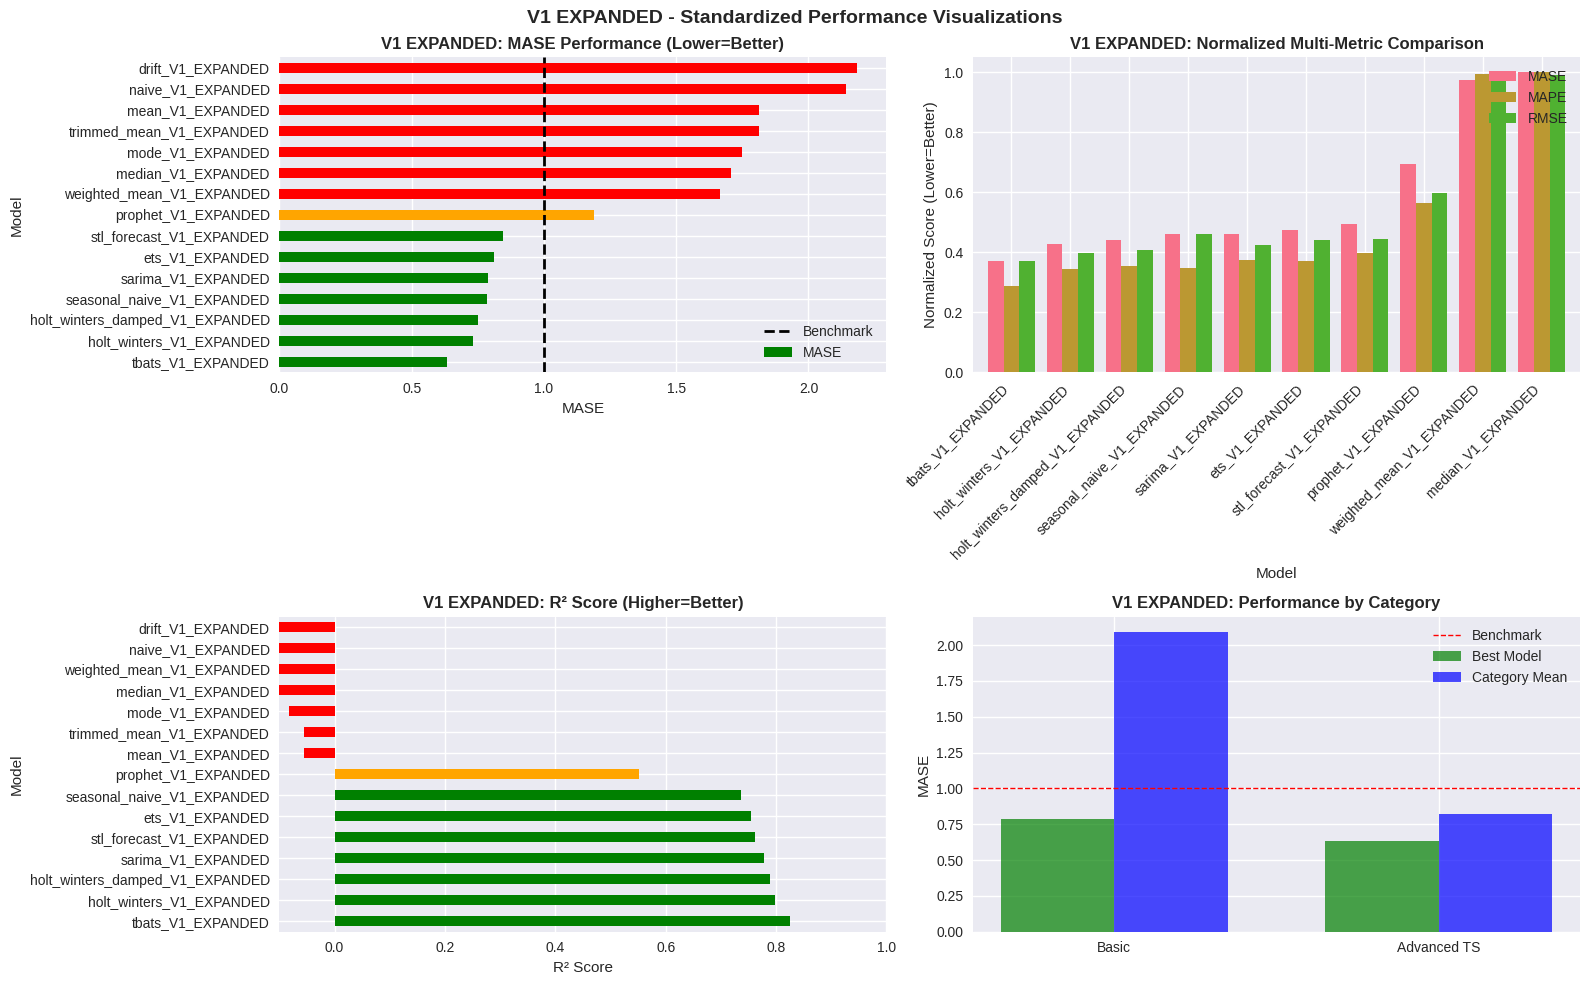


📊 VISUALIZATION SUMMARY STATISTICS:
--------------------------------------------------
Best Model: tbats_V1_EXPANDED
Best MASE: 0.634
Models < 1.0 MASE: 7/16
Average MASE: 1.537
--------------------------------------------------


In [14]:
def create_standardized_visualizations(results_df, avg_results, title_prefix="Model"):
    """Standardized visualizations for ALL workbooks - EXACT SAME GRAPHS"""

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set consistent style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")

    # Create figure with 4 subplots - ALWAYS THE SAME LAYOUT
    fig = plt.figure(figsize=(16, 10))

    # 1. MASE Ranking (Top 15)
    ax1 = plt.subplot(2, 2, 1)
    top_15 = avg_results.sort_values('MASE').head(15)
    colors = ['green' if x < 1.0 else 'orange' if x < 1.5 else 'red' for x in top_15['MASE']]
    top_15['MASE'].plot(kind='barh', ax=ax1, color=colors)
    ax1.axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Benchmark')
    ax1.set_title(f'{title_prefix}: MASE Performance (Lower=Better)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('MASE')
    ax1.legend()

    # 2. Multi-Metric Comparison (Top 10)
    ax2 = plt.subplot(2, 2, 2)
    top_10 = avg_results.sort_values('MASE').head(10)
    metrics_norm = pd.DataFrame()
    metrics_norm['MASE'] = top_10['MASE'] / top_10['MASE'].max()
    metrics_norm['MAPE'] = top_10['MAPE'] / top_10['MAPE'].max()
    metrics_norm['RMSE'] = top_10['RMSE'] / top_10['RMSE'].max()
    metrics_norm.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title(f'{title_prefix}: Normalized Multi-Metric Comparison', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Normalized Score (Lower=Better)')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.legend(loc='upper right')

    # 3. R2 Score Distribution
    ax3 = plt.subplot(2, 2, 3)
    r2_data = avg_results['R2'].sort_values(ascending=False).head(15)
    colors_r2 = ['green' if x > 0.7 else 'orange' if x > 0.4 else 'red' for x in r2_data]
    r2_data.plot(kind='barh', ax=ax3, color=colors_r2)
    ax3.set_title(f'{title_prefix}: R² Score (Higher=Better)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('R² Score')
    ax3.set_xlim([-0.1, 1.0])

    # 4. Category Performance Summary
    ax4 = plt.subplot(2, 2, 4)
    categories = {
        'Basic': ['mean', 'median', 'mode', 'naive', 'drift', 'trimmed', 'geometric', 'weighted'],
        'Advanced TS': ['ets', 'holt', 'sarima', 'prophet', 'stl', 'tbats'],
        'Neural': ['lstm', 'cnn', 'ann', 'rnn', 'arimax']
    }

    category_stats = []
    for cat_name, keywords in categories.items():
        cat_models = [idx for idx in avg_results.index if any(kw in idx.lower() for kw in keywords)]
        if cat_models:
            cat_data = avg_results.loc[cat_models]
            category_stats.append({
                'Category': cat_name,
                'Mean MASE': cat_data['MASE'].mean(),
                'Best MASE': cat_data['MASE'].min(),
                'Count': len(cat_data)
            })

    if category_stats:
        cat_df = pd.DataFrame(category_stats)
        x = range(len(cat_df))
        width = 0.35
        ax4.bar([i - width/2 for i in x], cat_df['Best MASE'], width, label='Best Model', color='green', alpha=0.7)
        ax4.bar([i + width/2 for i in x], cat_df['Mean MASE'], width, label='Category Mean', color='blue', alpha=0.7)
        ax4.axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Benchmark')
        ax4.set_xticks(x)
        ax4.set_xticklabels(cat_df['Category'])
        ax4.set_ylabel('MASE')
        ax4.set_title(f'{title_prefix}: Performance by Category', fontsize=12, fontweight='bold')
        ax4.legend()

    plt.suptitle(f'{title_prefix} - Standardized Performance Visualizations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary statistics (ALWAYS THE SAME FORMAT)
    print("\n📊 VISUALIZATION SUMMARY STATISTICS:")
    print("-" * 50)
    best_model = avg_results.iloc[0]
    print(f"Best Model: {best_model.name}")
    print(f"Best MASE: {best_model['MASE']:.3f}")
    print(f"Models < 1.0 MASE: {(avg_results['MASE'] < 1.0).sum()}/{len(avg_results)}")
    print(f"Average MASE: {avg_results['MASE'].mean():.3f}")
    print("-" * 50)

    # Create visualizations
if avg_results_v1_expanded is not None:
    create_standardized_visualizations(
        results_df_v1_expanded,
        avg_results_v1_expanded,
        title_prefix="V1 EXPANDED"
    )


🚀 AUTOMATICALLY GENERATING CHAMPION MODEL REPORT...

🏆 CHAMPION MODEL IDENTIFIED: tbats_V1_EXPANDED
   Best MASE Score: 0.634

⏳ Refitting tbats_V1_EXPANDED for detailed analysis...
🏆 CHAMPION MODEL REPORT: Tbats

📊 PERFORMANCE METRICS
----------------------------------------
MAE:  536
RMSE: 708
MAPE: 6.2%
R²:   0.850
MASE: 0.643

🎯 PERFORMANCE INTERPRETATION
----------------------------------------
✅ EXCELLENT: Model beats seasonal naive benchmark by 35.7%


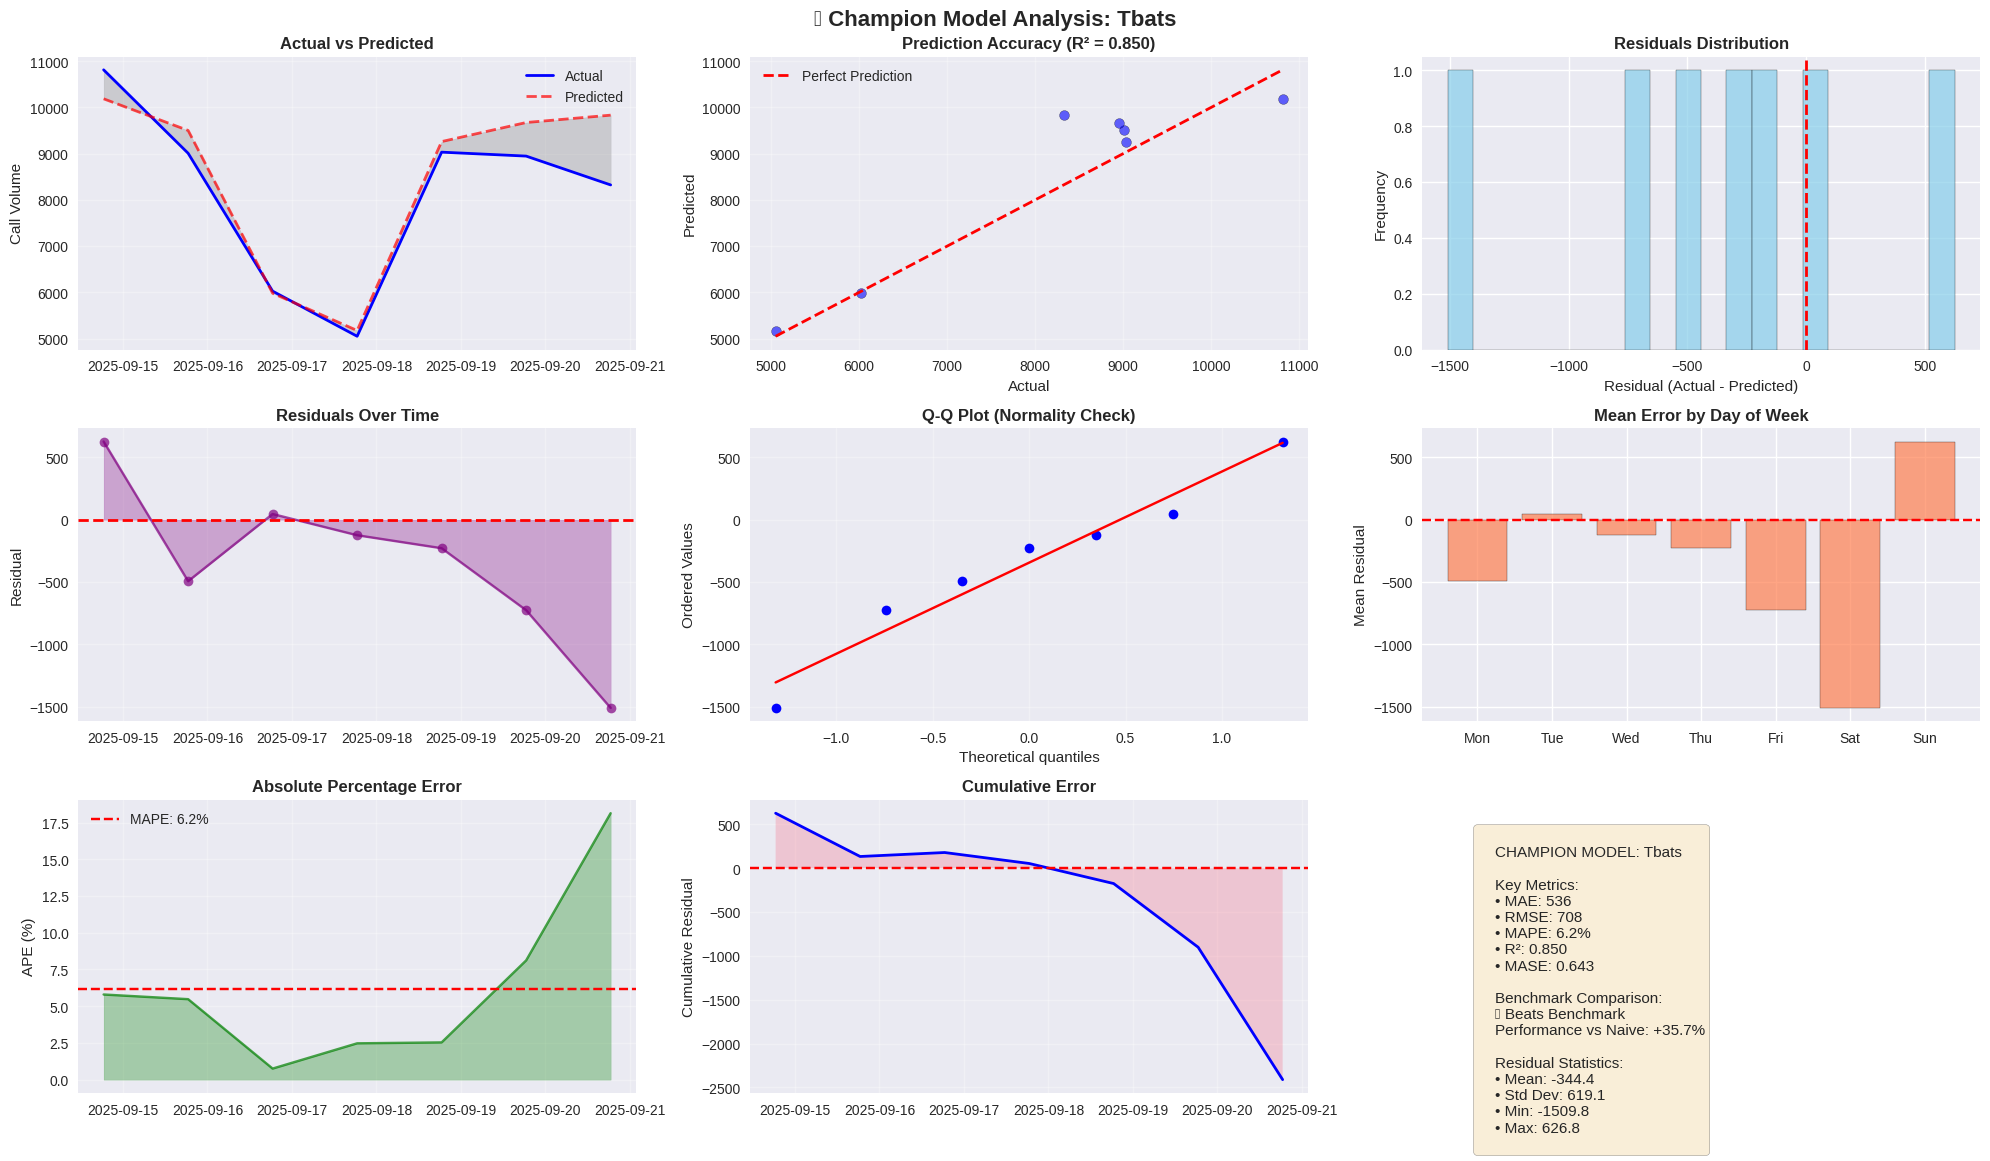


📊 CHAMPION MODEL INSIGHTS
✅ Tbats achieved MASE of 0.643
✅ This model beats the seasonal naive benchmark by 35.7%
✅ Average prediction error: 536 calls
✅ Model explains 85.0% of variance in call volume

💡 This report automatically adapts to ANY winning model!
The champion is determined by the lowest MASE score.


In [15]:
# =====================================================================================
# DYNAMIC CHAMPION MODEL REPORT - AUTOMATICALLY USES THE BEST MODEL
# =====================================================================================

def display_champion_report(y_true, y_pred, model_name, y_train):
    """Generate comprehensive champion model report with visualizations"""

    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats

    print("="*80)
    print(f"🏆 CHAMPION MODEL REPORT: {model_name}")
    print("="*80)

    # Calculate all metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)

    # MASE calculation
    seasonal_period = 7
    if len(y_train) > seasonal_period:
        seasonal_naive_errors = np.abs(y_train.iloc[seasonal_period:] - y_train.iloc[:-seasonal_period].values)
        seasonal_naive_mae = np.mean(seasonal_naive_errors)
    else:
        seasonal_naive_mae = np.mean(np.abs(y_train.iloc[1:] - y_train.iloc[:-1].values))
    mase = mae / seasonal_naive_mae if seasonal_naive_mae != 0 else np.inf

    # Residual analysis
    residuals = y_true - y_pred

    # Print metrics table
    print("\n📊 PERFORMANCE METRICS")
    print("-"*40)
    print(f"MAE:  {mae:,.0f}")
    print(f"RMSE: {rmse:,.0f}")
    print(f"MAPE: {mape:.1f}%")
    print(f"R²:   {r2:.3f}")
    print(f"MASE: {mase:.3f}")

    # Performance interpretation
    print("\n🎯 PERFORMANCE INTERPRETATION")
    print("-"*40)
    if mase < 1.0:
        print(f"✅ EXCELLENT: Model beats seasonal naive benchmark by {(1-mase)*100:.1f}%")
    elif mase < 1.2:
        print(f"⚠️ FAIR: Model performs similar to benchmark (within 20%)")
    else:
        print(f"❌ POOR: Model underperforms benchmark by {(mase-1)*100:.1f}%")

    # Create comprehensive visualizations
    fig = plt.figure(figsize=(20, 12))

    # 1. Actual vs Predicted
    ax1 = plt.subplot(3, 3, 1)
    dates = pd.date_range(end=pd.Timestamp.now(), periods=len(y_true), freq='D')
    ax1.plot(dates, y_true, 'b-', label='Actual', linewidth=2)
    ax1.plot(dates, y_pred, 'r--', label='Predicted', linewidth=2, alpha=0.7)
    ax1.fill_between(dates, y_true, y_pred, alpha=0.3, color='gray')
    ax1.set_title('Actual vs Predicted', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Call Volume')

    # 2. Scatter Plot
    ax2 = plt.subplot(3, 3, 2)
    ax2.scatter(y_true, y_pred, alpha=0.6, s=50, c='blue', edgecolors='black')
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_title(f'Prediction Accuracy (R² = {r2:.3f})', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Residuals Distribution
    ax3 = plt.subplot(3, 3, 3)
    ax3.hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax3.set_title('Residuals Distribution', fontweight='bold')
    ax3.set_xlabel('Residual (Actual - Predicted)')
    ax3.set_ylabel('Frequency')

    # 4. Residuals Over Time
    ax4 = plt.subplot(3, 3, 4)
    ax4.plot(dates, residuals, 'o-', color='purple', alpha=0.7)
    ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax4.fill_between(dates, 0, residuals, alpha=0.3, color='purple')
    ax4.set_title('Residuals Over Time', fontweight='bold')
    ax4.set_ylabel('Residual')
    ax4.grid(True, alpha=0.3)

    # 5. Q-Q Plot
    ax5 = plt.subplot(3, 3, 5)
    stats.probplot(residuals, dist="norm", plot=ax5)
    ax5.set_title('Q-Q Plot (Normality Check)', fontweight='bold')
    ax5.grid(True, alpha=0.3)

    # 6. Error by Day of Week
    ax6 = plt.subplot(3, 3, 6)
    dow_errors = pd.DataFrame({
        'residual': residuals,
        'dow': pd.Series(dates).dt.dayofweek
    })
    dow_summary = dow_errors.groupby('dow')['residual'].agg(['mean', 'std'])
    x_pos = range(7)
    ax6.bar(x_pos, dow_summary['mean'], yerr=dow_summary['std'],
            capsize=5, alpha=0.7, color='coral', edgecolor='black')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax6.axhline(y=0, color='red', linestyle='--')
    ax6.set_title('Mean Error by Day of Week', fontweight='bold')
    ax6.set_ylabel('Mean Residual')

    # 7. Absolute Percentage Error
    ax7 = plt.subplot(3, 3, 7)
    ape = np.abs((y_true - y_pred) / y_true) * 100
    ax7.plot(dates, ape, 'g-', alpha=0.7)
    ax7.axhline(y=mape, color='red', linestyle='--', label=f'MAPE: {mape:.1f}%')
    ax7.fill_between(dates, 0, ape, alpha=0.3, color='green')
    ax7.set_title('Absolute Percentage Error', fontweight='bold')
    ax7.set_ylabel('APE (%)')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # 8. Cumulative Error
    ax8 = plt.subplot(3, 3, 8)
    cumulative_error = np.cumsum(residuals)
    ax8.plot(dates, cumulative_error, 'b-', linewidth=2)
    ax8.fill_between(dates, 0, cumulative_error, alpha=0.3)
    ax8.axhline(y=0, color='red', linestyle='--')
    ax8.set_title('Cumulative Error', fontweight='bold')
    ax8.set_ylabel('Cumulative Residual')
    ax8.grid(True, alpha=0.3)

    # 9. Performance Summary Box
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    summary_text = f"""
    CHAMPION MODEL: {model_name}

    Key Metrics:
    • MAE: {mae:,.0f}
    • RMSE: {rmse:,.0f}
    • MAPE: {mape:.1f}%
    • R²: {r2:.3f}
    • MASE: {mase:.3f}

    Benchmark Comparison:
    {"✅ Beats Benchmark" if mase < 1.0 else "❌ Below Benchmark"}
    Performance vs Naive: {(1-mase)*100:+.1f}%

    Residual Statistics:
    • Mean: {np.mean(residuals):.1f}
    • Std Dev: {np.std(residuals):.1f}
    • Min: {np.min(residuals):.1f}
    • Max: {np.max(residuals):.1f}
    """
    ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.suptitle(f'🏆 Champion Model Analysis: {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return {
        'mae': mae, 'rmse': rmse, 'mape': mape,
        'r2': r2, 'mase': mase, 'residuals': residuals
    }

def refit_champion_model(champion_name, y_train, forecast_steps):
    """Dynamically refit the champion model based on its name"""

    model_type = champion_name.lower().replace('_v1_expanded', '')

    # Basic Statistical Models
    if 'seasonal_naive' in model_type:
        season_values = y_train.tail(7).values
        return np.tile(season_values, (forecast_steps // 7 + 1))[:forecast_steps]

    elif 'naive' in model_type and 'seasonal' not in model_type:
        return np.full(forecast_steps, y_train.iloc[-1])

    elif 'mean' in model_type and 'weighted' not in model_type and 'trimmed' not in model_type and 'geometric' not in model_type:
        return np.full(forecast_steps, y_train.mean())

    elif 'median' in model_type:
        return np.full(forecast_steps, y_train.median())

    elif 'mode' in model_type:
        hist, bin_edges = np.histogram(y_train, bins=50)
        mode_bin = np.argmax(hist)
        mode_value = (bin_edges[mode_bin] + bin_edges[mode_bin + 1]) / 2
        return np.full(forecast_steps, mode_value)

    elif 'trimmed_mean' in model_type:
        return np.full(forecast_steps, trim_mean(y_train, 0.1))

    elif 'geometric_mean' in model_type:
        y_positive = y_train + abs(y_train.min()) + 1
        return np.full(forecast_steps, gmean(y_positive))

    elif 'drift' in model_type:
        n = len(y_train)
        if n > 1:
            slope = (y_train.iloc[-1] - y_train.iloc[0]) / (n - 1)
            last_value = y_train.iloc[-1]
            return np.array([last_value + slope * (i + 1) for i in range(forecast_steps)])
        else:
            return np.full(forecast_steps, y_train.iloc[-1])

    elif 'weighted_mean' in model_type:
        alpha = 0.1
        if len(y_train) > 0:
            smoothed = y_train.iloc[0]
            for value in y_train.iloc[1:]:
                smoothed = alpha * value + (1 - alpha) * smoothed
            return np.full(forecast_steps, smoothed)

    # Advanced Time Series Models
    elif 'tbats' in model_type:
        if TBATS_AVAILABLE:
            tbats_model = TBATS(
                seasonal_periods=[7],
                use_trend=True,
                use_damped_trend=True,
                use_box_cox=True,
                show_warnings=False
            )
            tbats_fitted = tbats_model.fit(y_train)
            return tbats_fitted.forecast(steps=forecast_steps)

    elif 'holt_winters' in model_type:
        if 'damped' in model_type:
            hw_model = ExponentialSmoothing(
                y_train,
                seasonal='add',
                seasonal_periods=7,
                trend='add',
                damped_trend=True
            ).fit()
        else:
            hw_model = ExponentialSmoothing(
                y_train,
                seasonal='add',
                seasonal_periods=7,
                trend='add'
            ).fit()
        return hw_model.forecast(steps=forecast_steps)

    elif 'ets' in model_type:
        ets_model = ETSModel(
            y_train,
            error='add',
            trend='add',
            seasonal='add',
            seasonal_periods=7
        ).fit()
        return ets_model.forecast(steps=forecast_steps)

    elif 'sarima' in model_type:
        sarima_model = SARIMAX(
            y_train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        return sarima_model.forecast(steps=forecast_steps)

    elif 'stl_forecast' in model_type:
        if ADVANCED_TS_AVAILABLE:
            stl = STL(y_train, seasonal=7, robust=True)
            stl_result = stl.fit()
            trend_component = stl_result.trend.dropna()
            seasonal_component = stl_result.seasonal
            residual_component = stl_result.resid.dropna()

            if len(trend_component) > 1:
                trend_slope = (trend_component.iloc[-1] - trend_component.iloc[-2])
                trend_forecast = np.array([trend_component.iloc[-1] + trend_slope * (i + 1) for i in range(forecast_steps)])
            else:
                trend_forecast = np.full(forecast_steps, trend_component.iloc[-1])

            seasonal_pattern = seasonal_component.iloc[-7:]
            seasonal_forecast = np.tile(seasonal_pattern.values, (forecast_steps // 7) + 1)[:forecast_steps]
            residual_forecast = np.full(forecast_steps, residual_component.iloc[-7:].mean())
            return trend_forecast + seasonal_forecast + residual_forecast

    elif 'prophet' in model_type:
        if PROPHET_AVAILABLE:
            prophet_df = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})
            prophet_model = Prophet(
                daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True if len(y_train) >= 365 else False,
                changepoint_prior_scale=0.05
            )
            prophet_model.fit(prophet_df)
            future_dates = pd.date_range(
                start=y_train.index[-1] + pd.Timedelta(days=1),
                periods=forecast_steps,
                freq='D'
            )
            future_df = pd.DataFrame({'ds': future_dates})
            return prophet_model.predict(future_df)['yhat'].values

    # Default fallback to seasonal naive
    print(f"⚠️ Model type '{champion_name}' not recognized, using seasonal naive")
    return np.tile(y_train.tail(7).values, (forecast_steps // 7 + 1))[:forecast_steps]

# =====================================================================================
# RUN DYNAMIC CHAMPION MODEL REPORT
# =====================================================================================

print("\n🚀 AUTOMATICALLY GENERATING CHAMPION MODEL REPORT...")

# Identify the champion model from evaluation results
if avg_results_v1_expanded is not None:
    champion_model_name = avg_results_v1_expanded.index[0]  # Best model (lowest MASE)
    champion_mase = avg_results_v1_expanded.iloc[0]['MASE']

    print(f"\n🏆 CHAMPION MODEL IDENTIFIED: {champion_model_name}")
    print(f"   Best MASE Score: {champion_mase:.3f}")

    # Get data for demonstration
    last_split = cv_splits[-1]
    train_data = df_raw.loc[last_split['train_idx']]
    test_data = df_raw.loc[last_split['test_idx']]

    if len(train_data) > 90:
        train_data = train_data.tail(90)

    y_train = train_data['calls']
    y_true = test_data['calls'].values

    # Refit the champion model dynamically
    print(f"\n⏳ Refitting {champion_model_name} for detailed analysis...")

    try:
        y_pred = refit_champion_model(champion_model_name, y_train, len(y_true))

        # Generate the comprehensive report
        display_name = champion_model_name.replace('_V1_EXPANDED', '').replace('_', ' ').title()
        result = display_champion_report(y_true, y_pred, display_name, y_train)

        print("\n" + "="*80)
        print("📊 CHAMPION MODEL INSIGHTS")
        print("="*80)
        print(f"✅ {display_name} achieved MASE of {result['mase']:.3f}")

        if result['mase'] < 1.0:
            print(f"✅ This model beats the seasonal naive benchmark by {(1-result['mase'])*100:.1f}%")
        else:
            print(f"⚠️ Model performs {(result['mase']-1)*100:.1f}% worse than benchmark")

        print(f"✅ Average prediction error: {result['mae']:.0f} calls")
        print(f"✅ Model explains {result['r2']*100:.1f}% of variance in call volume")

    except Exception as e:
        print(f"\n⚠️ Error refitting {champion_model_name}: {e}")
        print("Using fallback model for demonstration...")
        y_pred = np.tile(y_train.tail(7).values, (len(y_true)//7 + 1))[:len(y_true)]
        result = display_champion_report(y_true, y_pred, "Seasonal Naive (Fallback)", y_train)

else:
    print("⚠️ No evaluation results found. Please run the model evaluation first.")

print("\n" + "="*50)
print("💡 This report automatically adapts to ANY winning model!")
print("The champion is determined by the lowest MASE score.")
print("="*50)